### Discovery of interesting peak-gene pairs

In [2]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt 
import anndata as ad
import requests

In [3]:
# load data
rna_adata = ad.read_h5ad('./data/rna.h5ad')
atac_adata = ad.read_h5ad('./data/atac.h5ad')
atac_adata.var.index = atac_adata.var.index.map(lambda peak: peak[9:])
atac_adata.var.index.name = 'Peak'
gene_locations = pd.read_table('./data/gene_locations_hg38.tsv', index_col = 'Gene ID', usecols = ['Gene ID', 'Begin', 'End', 'Chromosome', 'Symbol', 'Gene Type', 'Accession'])
gene_locations.drop(index = [idx for idx, accession in gene_locations['Accession'].items() if not accession.startswith('NC')], inplace = True)

#### Prior knowledge validation

Based on prior heart studies in mice, we expect to see:
- Periostin (Postn) expression to increase with TAC and decrease with TAC+JQ1
- MEOX1 expression to increase with TAC and decrease with TAC+JQ1
- MEOX1 peaks to increase with TAC and decrease with TAC+JQ1
  - This data is human so peaks will likely not be 1:1 with mice data

In [4]:
palette = {'Unstim': '#2ca02c', 'TGFb': '#d62728', 'TGFb+JQ1': '#1f77b4'}
markers = {'Lung': 'o', 'Heart': '^', 'Liver': 's'}

diverging_palette = 'vlag'
hue_norm = lambda: mpl.colors.SymLogNorm(1)
sm = lambda hnorm: plt.cm.ScalarMappable(cmap=diverging_palette, norm=hnorm)

In [5]:
# boxplot of expression over organ/condition
def plot_expression(adata: ad.AnnData, gene: str, layer: str = None, **kwargs) -> plt.Axes:
  gene_rna_adata = adata[:, adata.var['gene'] == gene]
  ax = sns.boxplot(gene_rna_adata.obs, x = 'organ', y = gene_rna_adata.to_df(layer = layer).sum(axis = 1), order=markers.keys(), hue = 'condition', palette=palette, hue_order = palette.keys(), **kwargs)
  ax.set_ylabel(f'{gene} expression {layer if layer is not None else ""}')
  return ax

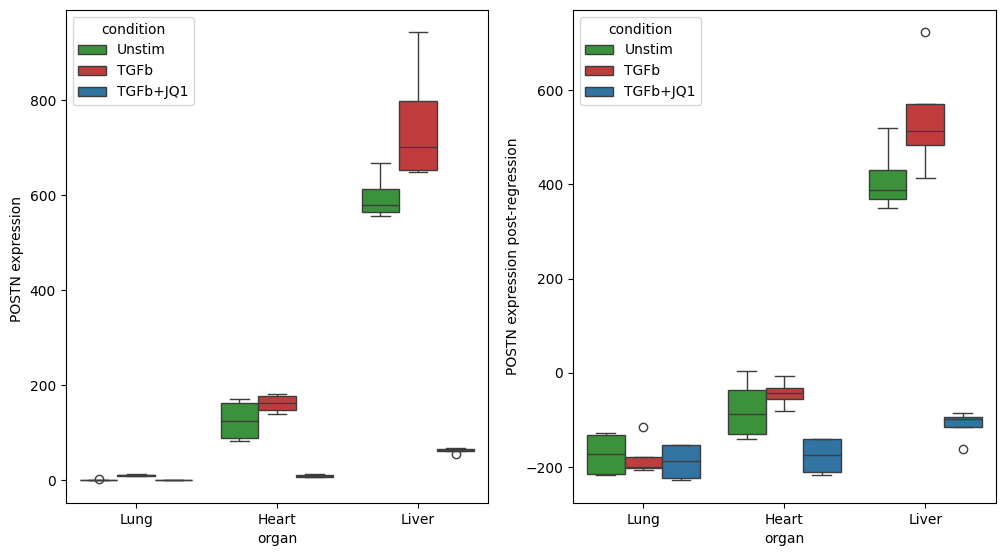

In [6]:
# Periostin expression pre- and post-regression
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_expression(rna_adata, gene = 'POSTN', ax=ax1)
plot_expression(rna_adata, gene = 'POSTN', layer = 'post-regression', ax=ax2)
plt.show()

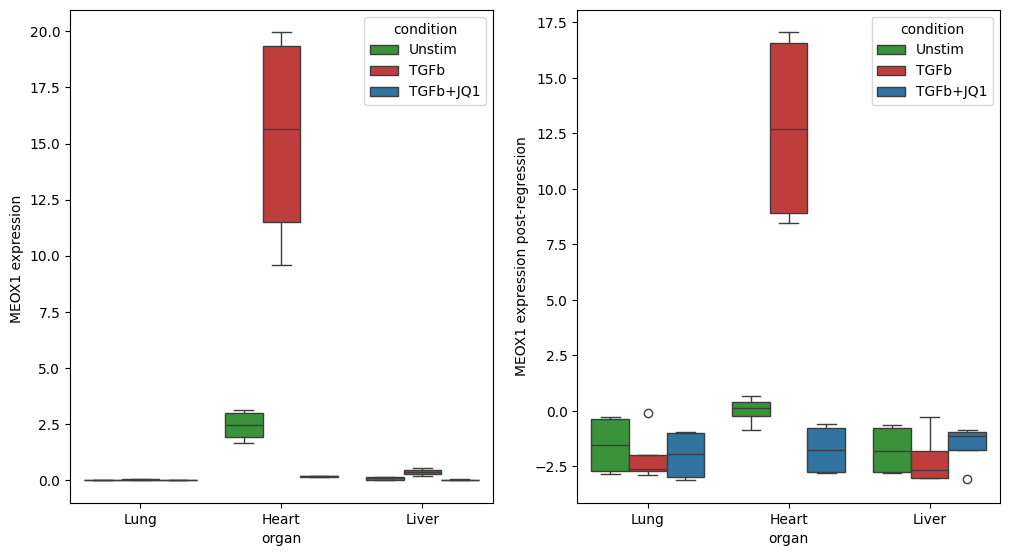

In [7]:
# MEOX1 expression
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_expression(rna_adata, gene = 'MEOX1', ax=ax1)
plot_expression(rna_adata, gene = 'MEOX1', layer = 'post-regression', ax=ax2)
plt.show()

In [8]:
# heatmap of atac peaks over location range. also boxes the (approximate) gene location
def plot_peak_range(adata: ad.AnnData, chr: int, loc: tuple[float, float], layer: str = None, range = 1.5 * 10 ** 5, **kwargs) -> plt.Axes:
  peak_adata = adata[:, (adata.var['Chr'] == f'chr{chr}') & (adata.var['End'] >= loc[0] - range) & (adata.var['Start'] <= loc[1] + range)]
  peak_heatmap_df = pd.DataFrame({
    f"{organ}-{condition}": {
      peak: np.mean(peak_adata[rows.index, peak]._get_X(layer = layer)) for peak in peak_adata.var_names
    }
    for (organ, condition), rows in peak_adata.obs.groupby(['organ', 'condition'])
  }, dtype = 'float64')
  peak_heatmap_df = peak_heatmap_df[[f"{organ}-{condition}" for organ in markers.keys() for condition in palette.keys()]]
  ax = sns.heatmap(peak_heatmap_df, cmap = 'viridis', **kwargs)
  ax.set_ylabel("Peak")
  ax.set_xlabel("Organ-Condition")
  coding_index = peak_adata[:, (peak_adata.var['End'] >= loc[0]) & (peak_adata.var['Start'] <= loc[1])].var_names
  ax.add_patch(plt.Rectangle((0, peak_heatmap_df.index.get_loc(coding_index[0])), len(peak_heatmap_df.columns), len(coding_index), fill=False, edgecolor='crimson', lw=2, clip_on=False))
  return ax

In [9]:
meox1_row = gene_locations[gene_locations['Symbol'] == 'MEOX1']
meox1_row

,Accession,Begin,End,Chromosome,Symbol,Gene Type
Gene ID,,,,,,
4222,NC_000017.11,43640389,43661922,17,MEOX1,protein-coding


In [10]:
meox1_row[['Begin', 'End']].values[0]

array([43640389, 43661922])

/scratch/ipykernel_1745465/2366565480.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (organ, condition), rows in peak_adata.obs.groupby(['organ', 'condition'])
/scratch/ipykernel_1745465/2366565480.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (organ, condition), rows in peak_adata.obs.groupby(['organ', 'condition'])


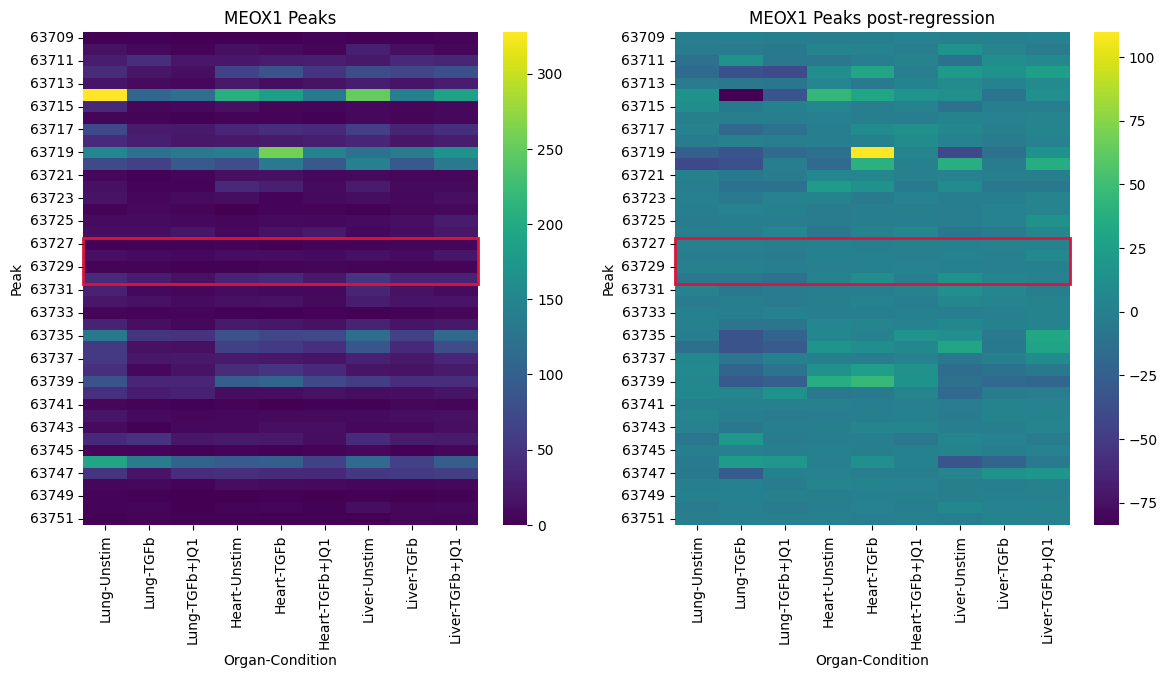

In [11]:
# MEOX1 peaks (Location according to UCSC is chr17, 43.64 - 43.66 Mb, expanding 150kb on either end)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(14, 6.4))
plot_peak_range(atac_adata, chr=meox1_row['Chromosome'].values[0], loc=meox1_row[['Begin', 'End']].values[0], ax=ax1)
ax1.set_title("MEOX1 Peaks")
plot_peak_range(atac_adata, chr=meox1_row['Chromosome'].values[0], loc=meox1_row[['Begin', 'End']].values[0], ax=ax2, layer='post-regression')
ax2.set_title("MEOX1 Peaks post-regression")
plt.show()

In [12]:
# chr17:43,616,437-43,616,691 <- orthologous to mouse peak 5
# chr17:43,616,835-43,617,184 <- orthologous to mouse peak 5
# not captured in this data
atac_adata[:, ['63723', '63724']].var

,Chr,Start,End,Strand,Length
Peak,,,,,
63723,chr17,43614858,43615602,+,745
63724,chr17,43622133,43622721,+,589


In [13]:
# chr17:43,591,770-43,592,120 <- orthologous to mouse peak 10
# chr17:43,592,215-43,592,517 <- orthologous to mouse peak 9
# 63720 seems to bridge both of these intervals
atac_adata[:, '63720'].var

,Chr,Start,End,Strand,Length
Peak,,,,,
63720,chr17,43591191,43592816,+,1626


In [14]:
# chr17:43,577,707-43,577,887 <- orthologous to mouse peak 13
# chr17:43,578,079-43,578,427 <- orthologous to mouse peak 13
# chr17:43,578,441-43,578,702 <- orthologous to mouse peak 13
# regions seem to be directly flanking
atac_adata[:, ['63718', '63719']].var

,Chr,Start,End,Strand,Length
Peak,,,,,
63718,chr17,43576650,43577072,+,423
63719,chr17,43578751,43580003,+,1253


In [15]:
# boxplot of peak over organ/condition
def plot_peak(adata: ad.AnnData, peak: str, layer: str = None, **kwargs) -> plt.Axes:
  ax = sns.boxplot(adata.obs, x = 'organ', y = adata[:, peak].to_df(layer = layer).sum(axis = 1), order=markers.keys(), hue = 'condition', palette=palette, hue_order = palette.keys(), **kwargs)
  ax.set_ylabel(f'{peak} consensus peaks {layer if layer is not None else ""}')
  return ax

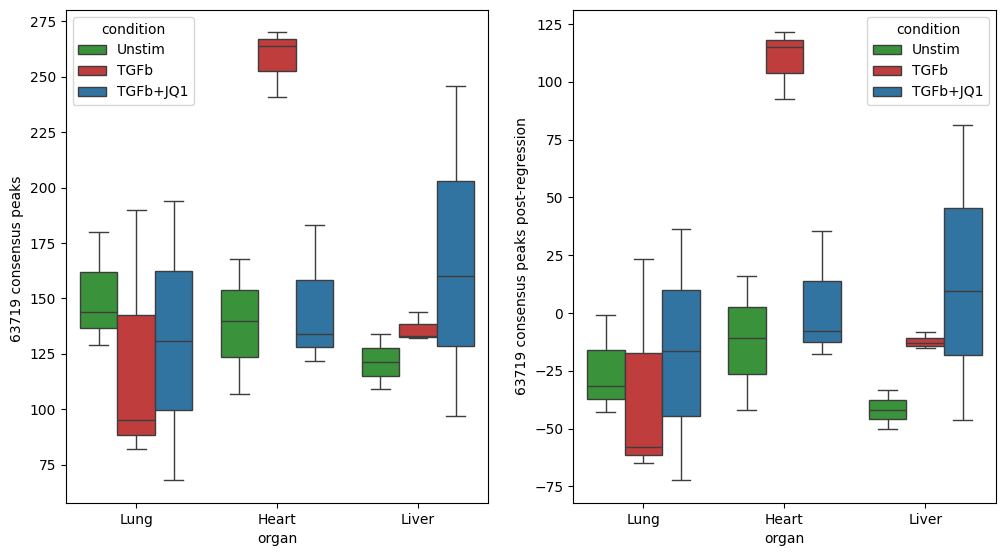

In [16]:
# Meox1 peaks
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_peak(atac_adata, peak = '63719', ax=ax1)
plot_peak(atac_adata, peak = '63719', ax=ax2, layer = 'post-regression')
plt.show()

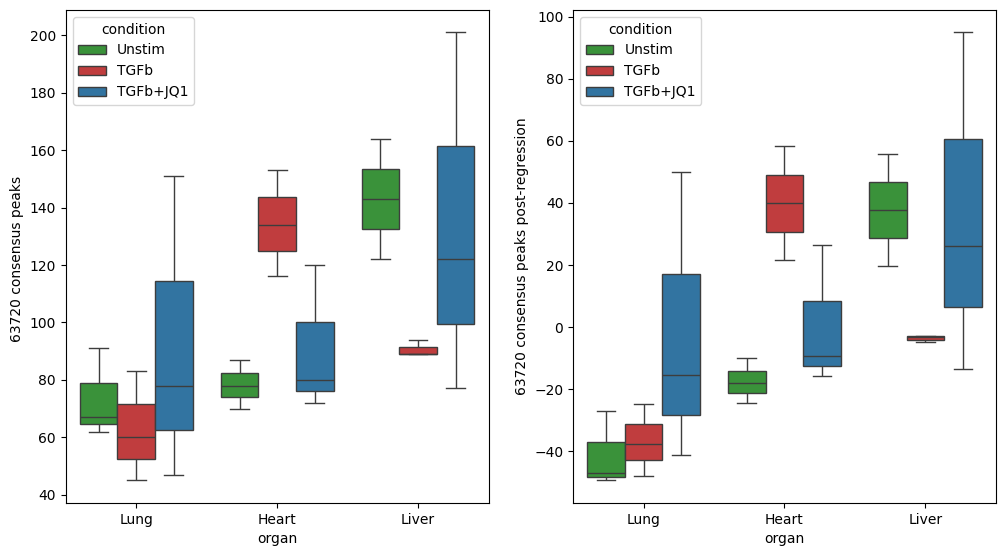

In [17]:
# Meox1 peaks
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_peak(atac_adata, peak = '63720', ax=ax1)
plot_peak(atac_adata, peak = '63720', ax=ax2, layer = 'post-regression')
plt.show()

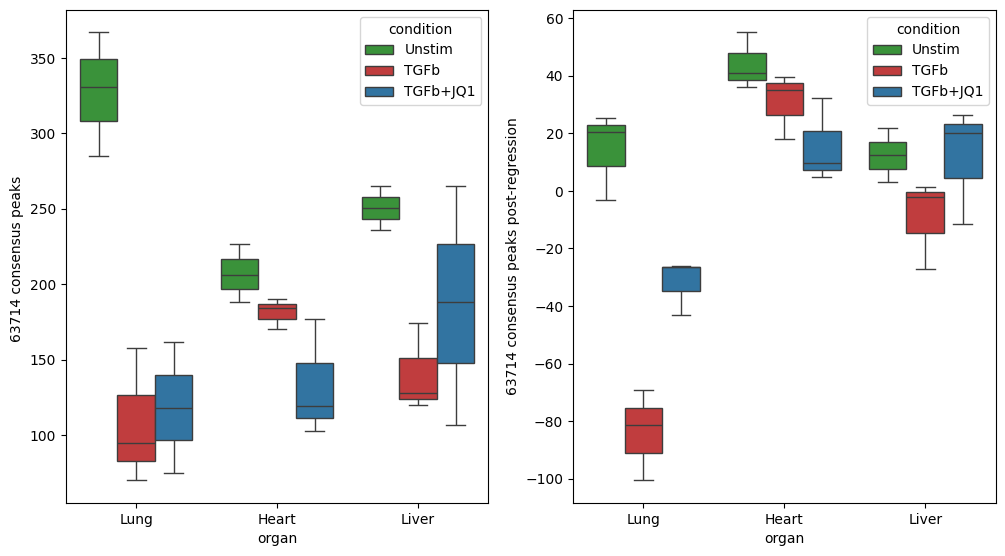

In [18]:
# Meox1 peaks
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_peak(atac_adata, peak = '63714', ax=ax1)
plot_peak(atac_adata, peak = '63714', ax=ax2, layer = 'post-regression')
plt.show()

### Methodology for identifying interesting peak-gene pairs
1. In one organ, identify genes with increased expression in TGFb and reduced in Unstim/JQ1.
2. For each gene, look within 150kb of TSS and identify peaks that show the same pattern across conditions.
3. Repeat steps 1 and 2 for each organ.
4. Compare/contrast peak-gene pairs across organs.
    - Can we identify organ-specific genes/enhancers?
    - Can we identify shared genes/enhancers?

Start by deep diving on heart!

In [19]:
def calc_condition_gene_averages(adata: ad.AnnData, organ: str, layer: str = None) -> pd.DataFrame:
  organ_adata = adata[adata.obs['organ'] == organ, :]
  organ_df = organ_adata.to_df(layer = layer)
  organ_df['condition'] = organ_adata.obs['condition']
  condition_avg_df = organ_df.groupby('condition', observed = False).aggregate('mean').T  # Average across replicates
  condition_avg_df['gene'] = organ_adata.var['gene']
  return condition_avg_df.groupby('gene', observed = False).aggregate('sum')  # Sum across gene variants

Scores calculated by the following formula (sign-adjusted):
$$s = \log_2(\text{mean}) * \log_2\frac{\text{TGFb}}{\text{Unstim}} * \log_2\frac{\text{TGFb+JQ1}}{\text{TGFb}}$$

Performed for both RNA and ATAC data. All values +1 to avoid divide by 0 and sign issues

In [166]:
def calc_lfc(organ_df: pd.DataFrame) -> pd.DataFrame:
  """Uses log fold change to determine which genes are up- and down-regulated in each condition"""
  odf_copy = organ_df + 1
  lfc_df = pd.DataFrame({
    'up': np.sqrt(np.log2(odf_copy.mean(axis = 1))) * np.log2(odf_copy['TGFb'] / odf_copy['Unstim']),
    'down': np.sqrt(np.log2(odf_copy.mean(axis = 1))) * np.log2(odf_copy['TGFb+JQ1'] / odf_copy['TGFb']),
  })
  lfc_df['score'] = np.sign(np.sign(lfc_df['down']) - np.sign(lfc_df['up'])) * lfc_df['up'] * lfc_df['down']
  return lfc_df

In [167]:
def find_organ_genes(organ_df: pd.DataFrame, up_by: int = 0, down_by: int = 0) -> list[str]:
  """Uses log fold change to determine which genes are up- and down-regulated in each condition"""
  upreg_genes = organ_df.index[(np.log2(organ_df['TGFb'] / organ_df['Unstim']) > up_by) & (np.log2(organ_df['TGFb+JQ1'] / organ_df['TGFb']) < down_by)]
  return upreg_genes

In [168]:
heart_rna_df = calc_condition_gene_averages(rna_adata, "Heart")
heart_rna_df.head()

condition,TGFb,TGFb+JQ1,Unstim
gene,,,
A1BG,1.130977,0.974347,1.287053
A1BG-AS1,1.837193,3.606701,1.548569
A1CF,0.001390,0.001376,0.000000
A2M,0.021714,0.005007,0.036045
A2M-AS1,0.107994,0.023121,0.074854


In [169]:
heart_gene_lfc_df = calc_lfc(heart_rna_df)
heart_gene_lfc_df.head()

,up,down,score
gene,,,
A1BG,-0.106532,-1.150626e-01,0.000000e+00
A1BG-AS1,0.203923,9.213071e-01,0.000000e+00
A1CF,0.000073,-7.485525e-07,5.469442e-11
A2M,-0.003473,-4.111016e-03,0.000000e+00
A2M-AS1,0.013559,-3.558559e-02,4.825137e-04


In [170]:
def plot_lfc(lfc_df: pd.DataFrame, label: bool = False, **kwargs) -> plt.Axes:
  hnorm = hue_norm()
  if 'hue' not in kwargs:
    kwargs['hue'] = 'score'
    kwargs['palette'] = diverging_palette
    kwargs['hue_norm'] = hnorm
  ax = sns.scatterplot(lfc_df, x = 'up', y = 'down', legend=None, **kwargs)
  if label:
    for (idx, point) in lfc_df.iterrows():
      plt.text(point['up'], point['down'], idx, size='small')
  plt.xlabel("LFC(add TGFb)")
  plt.ylabel("LFC(add JQ1)")
  plt.axhline(0, linestyle='--', color = "lightgray")
  plt.axvline(0, linestyle='--', color = "lightgray")
  plt.autoscale(False)
  if type(kwargs['hue']) == str and kwargs['hue'] == 'score':
    legend_ax = ax.figure.add_axes((0.93, 0.15, 0.02, 0.7))
    legend_ax.figure.colorbar(sm(hnorm), cax=legend_ax)
  return ax

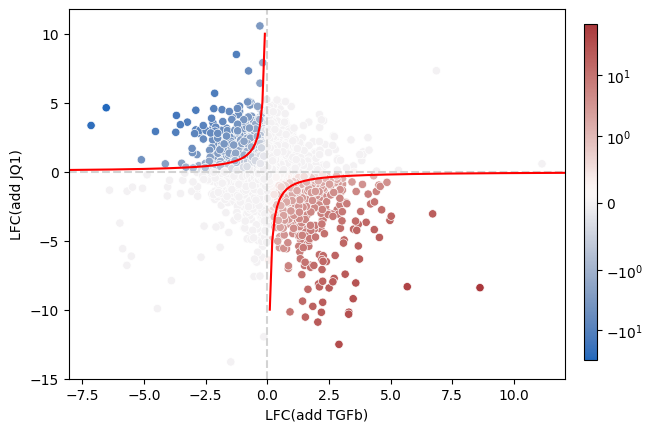

In [171]:
x = np.linspace(-100, 100, 2001)
with np.errstate(divide='ignore', invalid='ignore'):
  y = 1 / -x

ax = plot_lfc(heart_gene_lfc_df)
ax.plot(x, y, color = "red")
plt.show()

In [172]:
heart_rna_df.loc[['POSTN', 'MEOX1']]

condition,TGFb,TGFb+JQ1,Unstim
gene,,,
POSTN,162.404112,9.646059,126.615900
MEOX1,15.216120,0.173933,2.444118


In [173]:
heart_gene_lfc_df['score'][['POSTN', 'MEOX1']]

gene
POSTN     9.346945
MEOX1    23.673137
Name: score, dtype: float64

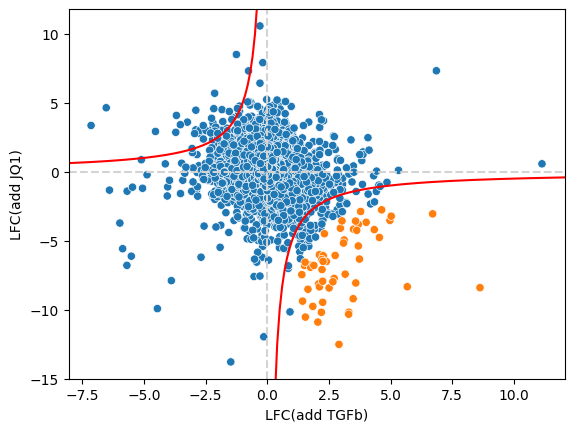

In [174]:
with np.errstate(divide='ignore', invalid='ignore'):
  y = 5 / -x

ax = plot_lfc(heart_gene_lfc_df, hue = heart_gene_lfc_df['score'] > 10)
ax.plot(x, y, color = "red")
plt.show()

In [175]:
def calc_condition_peak_averages(adata: ad.AnnData, organ: str, layer: str = None) -> pd.DataFrame:
  organ_adata = adata[adata.obs['organ'] == organ, :]
  organ_df = organ_adata.to_df(layer = layer)
  organ_df['condition'] = organ_adata.obs['condition']
  return organ_df.groupby('condition', observed = False).aggregate('mean').T  # Average across replicates

In [176]:
heart_atac_df = calc_condition_peak_averages(atac_adata, "Heart")

In [226]:
new_gene_locs = gene_locations.copy()
new_gene_locs.index = new_gene_locs['Symbol']
gene_to_idx = {
  gene: new_gene_locs.loc[gene] for gene in rna_adata.var['gene'].unique() if gene in new_gene_locs.index and len(new_gene_locs.loc[gene].shape) == 1
}

In [229]:
gene_to_peaks_map = {
  gene: atac_adata.var_names[(atac_adata.var['Chr'] == f'chr{row['Chromosome']}') & 
                             (atac_adata.var['End'] >= row['Begin'] - 1.5 * 10 ** 5) & 
                             (atac_adata.var['Start'] <= row['End'] + 1.5 * 10 ** 5)]
  for gene, row in gene_to_idx.items()
}

In [177]:
def peaks_for_good_genes(gene_lfc_df: pd.DataFrame, avg_peak_df: pd.DataFrame) -> dict[str, pd.DataFrame]:
  gene_to_peaks = {}
  for gene in gene_lfc_df.index:
    if not any(gene_locations['Symbol'] == gene):
      continue
    if sum(gene_locations['Symbol'] == gene) > 1:
      print(gene_locations.loc[gene_locations['Symbol'] == gene])
      continue
    chr, begin, end = gene_locations.loc[gene_locations['Symbol'] == gene][['Chromosome', 'Begin', 'End']].to_numpy().flatten()
    # chr, begin, end = row['Chromosome'], row['Begin'], row['End']
    peak_locs = atac_adata.var_names[
                                  (atac_adata.var['Chr'] == f'chr{chr}') & 
                                  (atac_adata.var['End'] >= begin - 1.5 * 10 ** 5) & 
                                  (atac_adata.var['Start'] <= end + 1.5 * 10 ** 5)]
    gene_subset_df = avg_peak_df.loc[peak_locs]
    peak_lfc_df = calc_lfc(gene_subset_df)
    gene_to_peaks[gene] = peak_lfc_df
  return gene_to_peaks

In [295]:
heart_peak_df = calc_lfc(heart_atac_df)

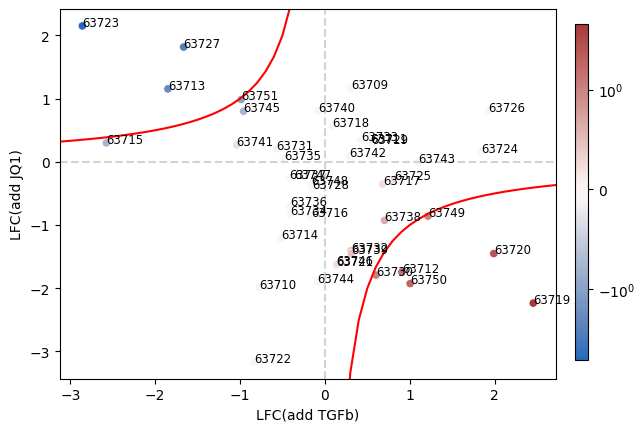

In [296]:
with np.errstate(divide='ignore', invalid='ignore'):
  y = 1 / -x

ax = plot_lfc(heart_peak_df.loc[gene_to_peaks_map['MEOX1']], label = True)
ax.plot(x, y, color = "red")
plt.show()

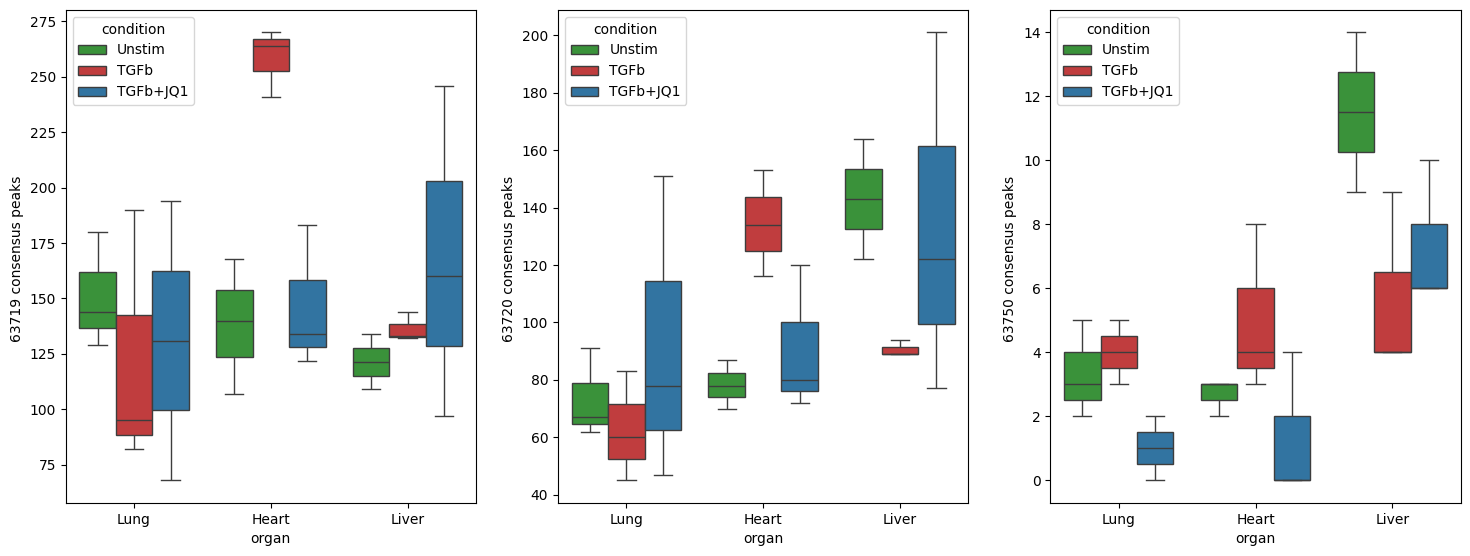

In [180]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(18, 6.4))
plot_peak(atac_adata, peak = '63719', ax=ax1)
plot_peak(atac_adata, peak = '63720', ax=ax2)
plot_peak(atac_adata, peak = '63750', ax=ax3)
plt.show()

In [237]:
def merge_gene_peak_lfc(gene_lfc_df: pd.DataFrame, peak_lfc_df: pd.DataFrame) -> pd.DataFrame:
  gene_peak_pair_df = pd.DataFrame({(gene, peak): {'gene_score': gene_lfc_df['score'][gene], 'peak_score':peak_lfc_df['score'][peak]} for gene, peaks in gene_to_peaks_map.items() for peak in peaks}).T
  gene_peak_pair_df.index.names = ['Gene', 'Peak']
  gene_peak_pair_df = gene_peak_pair_df.sort_values(['gene_score', 'peak_score'], ascending=False)
  return gene_peak_pair_df

In [182]:
def get_best_pg_pairs(gene_peak_pair_df: pd.DataFrame) -> list[tuple[str, str]]:
  max_gene_score, max_peak_score = gene_peak_pair_df.max()
  peak_coeff = max_gene_score / max_peak_score
  boundary = max_gene_score / 2
  return [(gene, gene_peak_pair_df.loc[gene, :].index[0]) for gene in gene_peak_pair_df.index.get_level_values(0).unique() if (gene_peak_pair_df.loc[gene, :]['gene_score'] + peak_coeff * gene_peak_pair_df.loc[gene, :]['peak_score'] > boundary).any()]

In [ ]:
heart_gene_peak_pair_df = merge_gene_peak_lfc(heart_gene_lfc_df, heart_peak_df)
best_heart_peaks = get_best_pg_pairs(heart_gene_peak_pair_df)

In [184]:
def plot_pg_pairs(gene_peak_pair_df: pd.DataFrame, best_peaks: list[tuple[str, str]] = [], **kwargs) -> plt.Axes: 
  plot_args = {
    **kwargs
  }
  if len(best_peaks) > 0:
    plot_args['hue'] = gene_peak_pair_df.index.isin(best_peaks)
  ax = sns.scatterplot(gene_peak_pair_df, x = 'gene_score', y = 'peak_score', legend = None, **plot_args)
  for (gene, peak) in best_peaks:
    point = gene_peak_pair_df.loc[(gene, peak)]
    ax.text(point['gene_score'], point['peak_score'], f'{gene}-{peak}', size='x-small', va='bottom')
  return ax

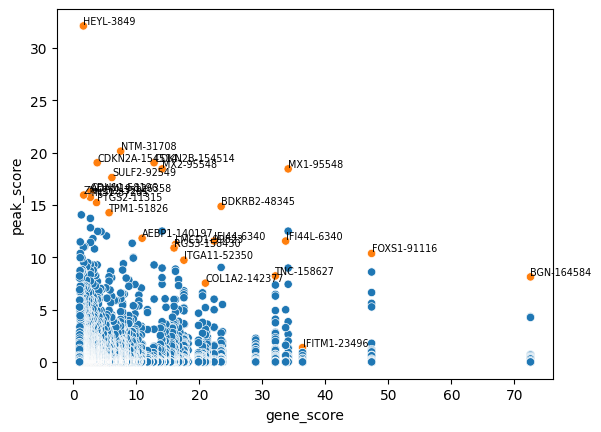

In [185]:
plot_pg_pairs(heart_gene_peak_pair_df, best_heart_peaks)
plt.show()

### Combining across organs

In [238]:
def run_organ_analysis(organ: str, layer: str = None) -> pd.DataFrame:
  organ_rna_df = calc_condition_gene_averages(rna_adata, organ, layer = layer)
  organ_gene_lfc_df = calc_lfc(organ_rna_df)
  organ_atac_df = calc_condition_peak_averages(atac_adata, organ, layer = layer)
  organ_peak_lfc_df = calc_lfc(organ_atac_df)
  organ_gene_peak_pair_df = merge_gene_peak_lfc(organ_gene_lfc_df, organ_peak_lfc_df)
  return organ_gene_peak_pair_df

In [239]:
organ_to_all_pg_pairs = {
  organ: run_organ_analysis(organ) for organ in markers.keys()
}

In [240]:
organ_to_best_pairs = {
  organ: get_best_pg_pairs(organ_to_all_pg_pairs[organ]) for organ in markers.keys()
}

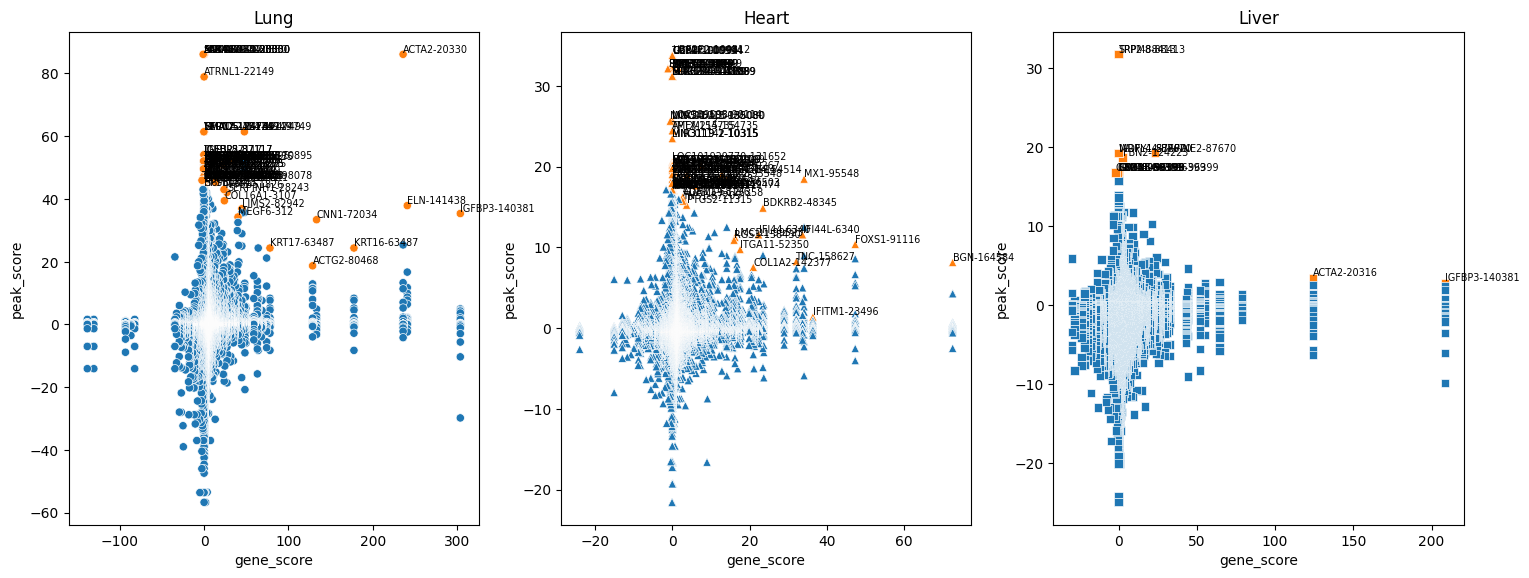

In [241]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6.4))
for (ax, organ) in zip(axs, markers.keys()):
  plot_pg_pairs(organ_to_all_pg_pairs[organ], organ_to_best_pairs[organ], ax=ax, marker=markers[organ])
  ax.set_title(organ)
plt.show()

In [242]:
combined_score_df = pd.concat(organ_to_all_pg_pairs.values(), axis = 'columns', keys = organ_to_all_pg_pairs.keys())
combined_score_df = combined_score_df.fillna(0.)
combined_score_df.to_csv('./data/pg_pairs.csv')
combined_score_df

Lung                 Heart                  Liver  \
               gene_score peak_score gene_score peak_score  gene_score   
Gene   Peak                                                              
IGFBP3 140381  303.596298  35.335848   1.559546   0.000000  208.559236   
       140389  303.596298   4.941446   1.559546   0.544415  208.559236   
       140392  303.596298   4.516195   1.559546   0.000000  208.559236   
       140394  303.596298   4.220600   1.559546   0.164744  208.559236   
       140391  303.596298   3.614890   1.559546   0.459782  208.559236   
...                   ...        ...        ...        ...         ...   
MT2A   57900  -138.362206   0.000000   0.000000   0.948960  -23.688266   
       57893  -138.362206  -1.389506   0.000000  -2.411596  -23.688266   
       57882  -138.362206  -6.991253   0.000000   0.000000  -23.688266   
       57876  -138.362206  -7.037122   0.000000  -1.759782  -23.688266   
       57883  -138.362206 -14.135121   0.000000   1.067576  -23.688266   

                          
              peak_score  
Gene   Peak               
IGFBP3 140381   2.806273  
       140389   2.377671  
       140392   0.000000  
       140394   0.772570  
       140391   0.000000  
...                  ...  
MT2A   57900   -1.942576  
       57893    0.000000  
       57882   -3.711087  
       57876   -6.620992  
       57883   -0.077276  

[613480 rows x 6 columns]

In [243]:
pairs_in_all = combined_score_df[~combined_score_df.lt(5.0).any(axis=1)].index

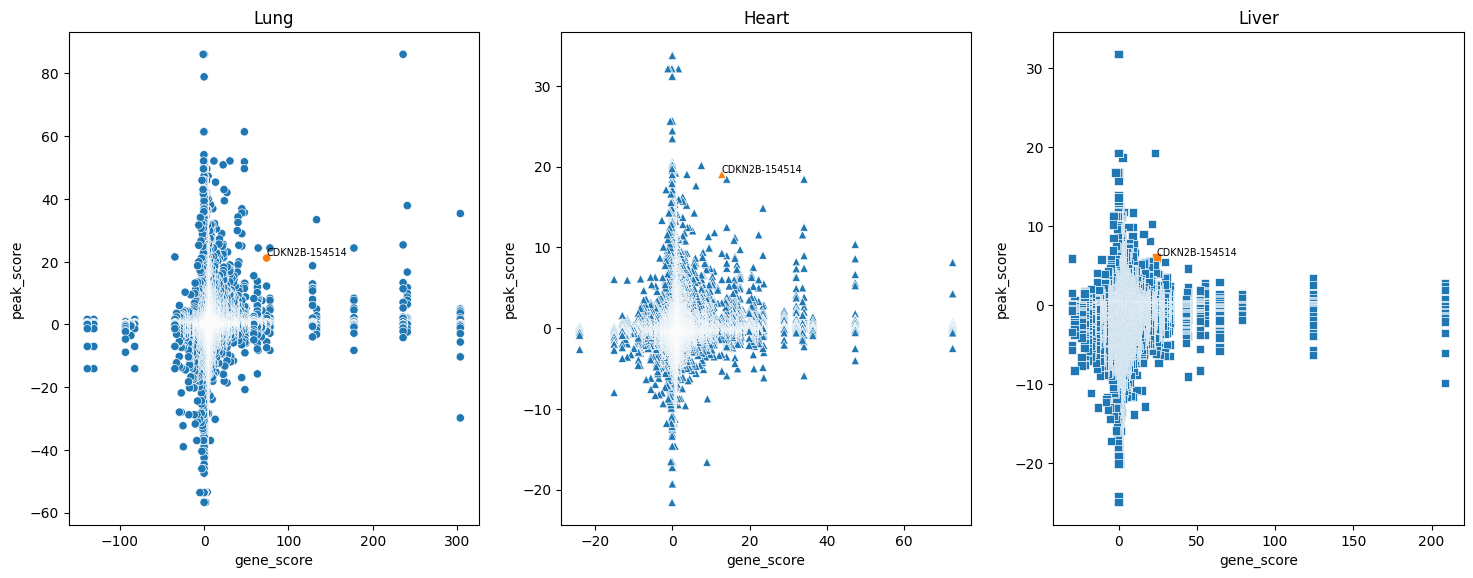

In [244]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6.4))
for (ax, organ) in zip(axs, markers.keys()):
  plot_pg_pairs(organ_to_all_pg_pairs[organ], pairs_in_all, ax=ax, marker=markers[organ])
  ax.set_title(organ)
plt.show()

### Organ Specificity Scoring

Above approach is a bit arbitrary... Let's instead calculate organ specificity scores for each peak and each gene.

Scores will be scaled to 0 to 1 for each datapoint. Maybe logarithmically instead of linearly?

$$o_i = s_i - \sum_{j\neq i} s_j$$

In [245]:
scaled_score_df = combined_score_df / combined_score_df.max()
scaled_score_df.head()

Lung                 Heart                 Liver  \
              gene_score peak_score gene_score peak_score gene_score   
Gene   Peak                                                            
IGFBP3 140381        1.0   0.410406   0.021499   0.000000        1.0   
       140389        1.0   0.057392   0.021499   0.016061        1.0   
       140392        1.0   0.052453   0.021499   0.000000        1.0   
       140394        1.0   0.049020   0.021499   0.004860        1.0   
       140391        1.0   0.041985   0.021499   0.013564        1.0   

                          
              peak_score  
Gene   Peak               
IGFBP3 140381   0.088449  
       140389   0.074941  
       140392   0.000000  
       140394   0.024350  
       140391   0.000000

In [ ]:
sums = scaled_score_df.T.groupby(level = 1).agg('sum').T
specificity_df = scaled_score_df.apply(lambda col: 2*col - sums[col.name[1]], axis = 0)
specificity_df = specificity_df.sort_values(list(specificity_df.columns), ascending=False)
specificity_df.head()

Lung                 Heart                 Liver           
            gene_score peak_score gene_score peak_score gene_score peak_score
Gene Peak                                                                    
ELN  141438   0.693717   0.439731  -0.892288  -0.439731  -0.693717  -0.439731
     141444   0.693717   0.205282  -0.892288   0.092398  -0.693717  -0.092398
     141448   0.693717   0.193516  -0.892288  -0.193516  -0.693717  -0.193516
     141433   0.693717   0.184917  -0.892288  -0.184917  -0.693717  -0.044552
     141455   0.693717   0.167885  -0.892288   0.151324  -0.693717  -0.151324

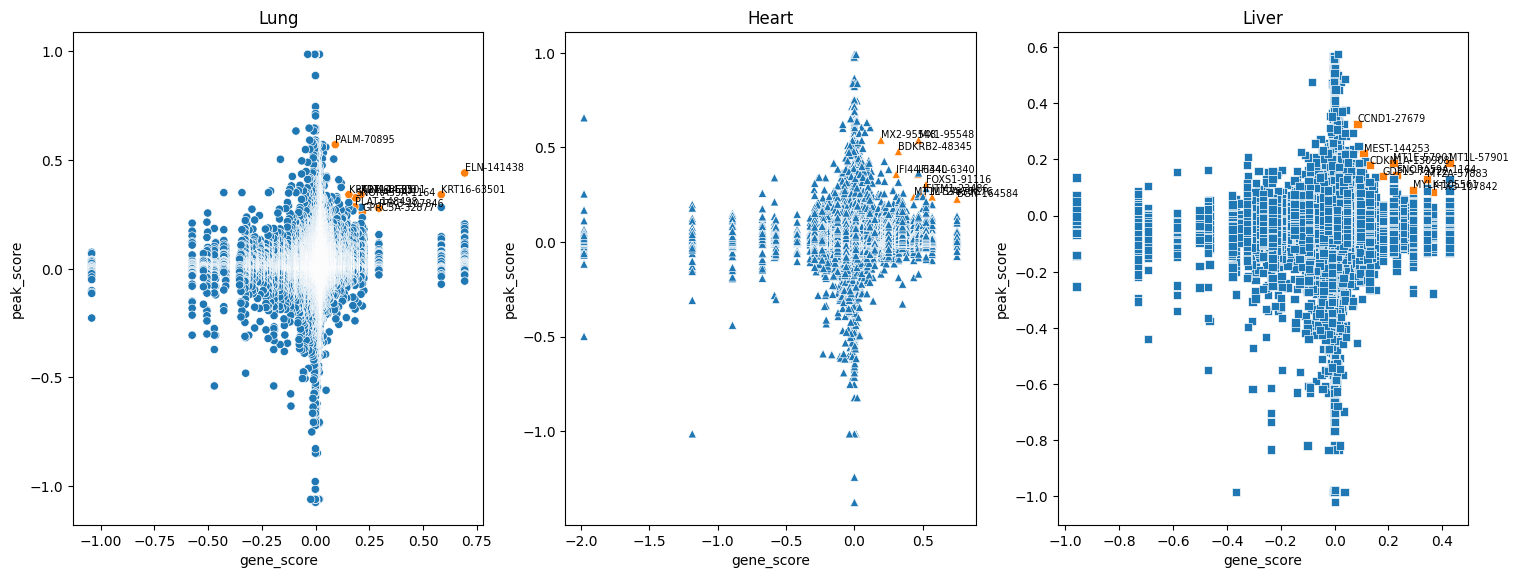

In [276]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6.4))
for (ax, organ) in zip(axs, markers.keys()):
  ordered_pairs = (specificity_df.T.groupby(level=0).agg('prod') * (np.sign(specificity_df[organ]['peak_score']) + np.sign(specificity_df[organ]['gene_score'])) - 1).T.sort_values(organ, ascending=False)
  top_genes = ordered_pairs.index.get_level_values(0).unique()[0:10]
  top_pairs = ordered_pairs.groupby(level=0).nth(0).loc[top_genes].index
  plot_pg_pairs(specificity_df[organ], top_pairs, ax=ax, marker=markers[organ])
  ax.set_title(organ)
plt.show()

<Axes: xlabel='organ', ylabel='141438 consensus peaks '>

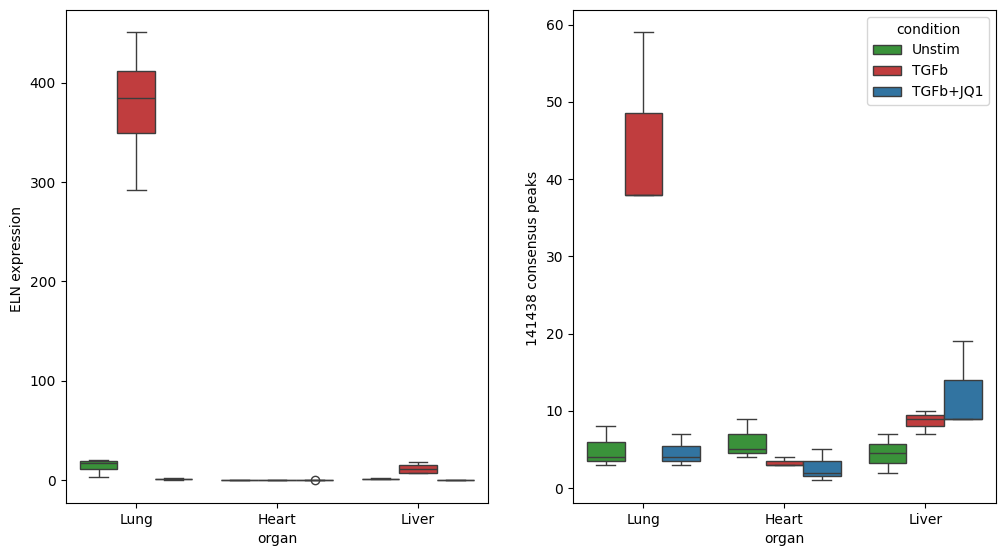

In [294]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_expression(rna_adata, 'ELN', ax=ax1, legend=False)
plot_peak(atac_adata, '141438', ax=ax2)

In [248]:
universal_df = (3 - specificity_df.abs().T.groupby(level = 1).agg('sum').T) * (scaled_score_df.T.groupby(level = 1).agg('mean').T)
universal_df.head()

gene_score  peak_score
Gene Peak                         
A1BG 75666    0.002165    0.045596
     75667    0.002165   -0.024462
     75668    0.002165    0.017514
     75669    0.002165    0.005177
     75670    0.002165    0.001237

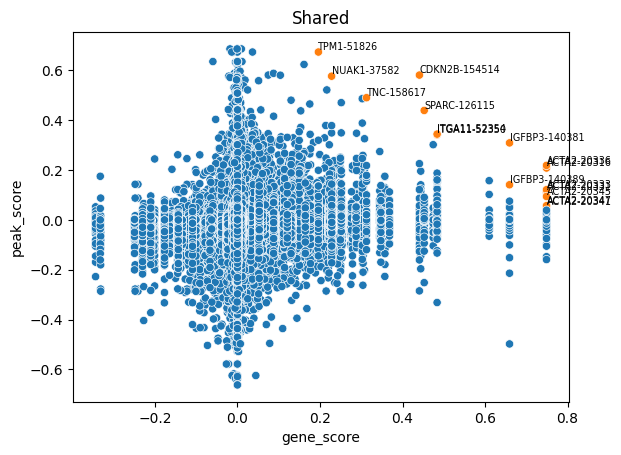

In [293]:
ordered_pairs = (universal_df.T.agg('prod') * np.sign(np.sign(universal_df['peak_score']) + np.sign(universal_df['gene_score']) - 1)).T.sort_values(ascending = False)
top_genes = ordered_pairs.index.get_level_values(0).unique()[0:10]
top_pairs = ordered_pairs.groupby(level=0).nth(0).loc[top_genes].index
ax = plot_pg_pairs(universal_df, universal_df.index[(universal_df['gene_score'] + universal_df['peak_score'] > 0.8)])
ax.set_title('Shared')
plt.show()

<Axes: xlabel='organ', ylabel='154514 consensus peaks '>

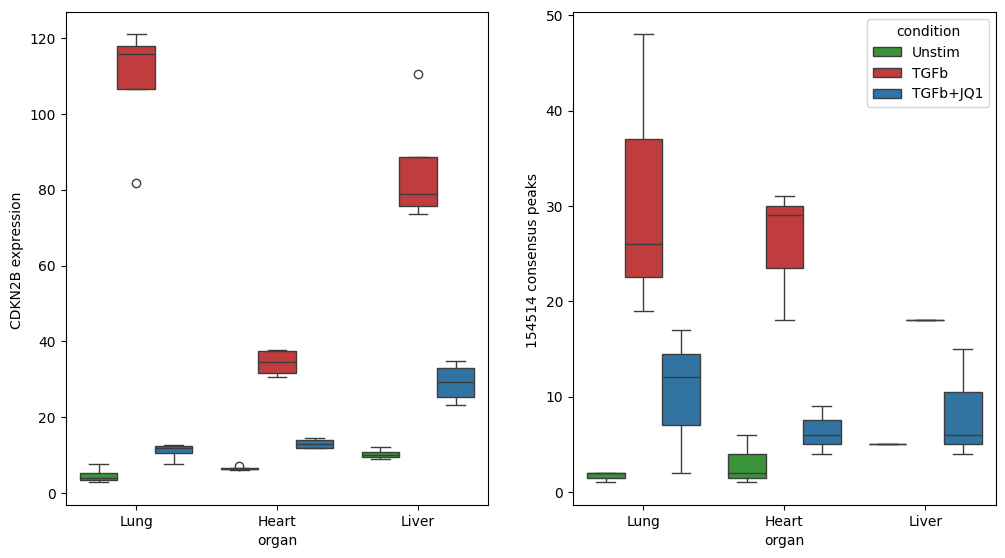

In [256]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_expression(rna_adata, 'CDKN2B', ax=ax1, legend=False)
plot_peak(atac_adata, '154514', ax=ax2)

### Determine Gene Functions

Cross-reference genes with [PantherDB](https://pantherdb.org/)/Gene Ontology to determine gene functional enrichment.

Cross-reference peaks with [Screen 2.0](https://screen.wenglab.org/) to determine previously identified cCREs. Ask Pawel - any recommendation for database to search for functional annotations of these cCREs?

In [ ]:
def functional_enrichment(gene_list: list[str]):
  query = {
    'organism': 9606,  # human
    'annotDataSet': 'GO:0008150',  # gene ontology for biological processes
    'geneInputList': ','.join(gene_list)
  }
  request = requests.post(
    "https://pantherdb.org/services/oai/pantherdb/enrich/overrep", 
    params=query
  )
  if request.status_code != 200:
      raise Exception("Query failed. Status code: {}.".format(request.status_code))
  result = request.json()
  enriched_functions = result['results']['result']
  return [(func['term']['label'], func['pValue']) for func in enriched_functions if func['pValue'] < 0.001]

In [ ]:
def get_screen_cCREs(peak_list: pd.DataFrame):
  variables = {
    "coordinates": [{ "chromosome": row['Chr'], "start": row["Start"], "end": row["End"] } for _idx, row in peak_list.iterrows()],
    "assembly": "grch38"
  }
  query = """
  query cCRESCREENSearch($assembly: String!, $coordinates: [GenomicRangeInput], ) { 
    cCRESCREENSearch(assembly: $assembly, coordinates: $coordinates) {
        info {
          accession
        }
        chrom
        start
        len
        pct     
        ctcf_zscore
        dnase_zscore
        atac_zscore
        enhancer_zscore
        promoter_zscore
      }
  }
  """
  request = requests.post(
      'https://factorbook.api.wenglab.org/graphql',
      json={ 'query': query, 'variables': variables },
      headers={}
  )
  if request.status_code != 200:
      raise Exception("Query failed. Status code: {}.".format(request.status_code))
  result = request.json()
  cCREs = sorted(result['data']['cCRESCREENSearch'], key = lambda cCRE: cCRE['enhancer_zscore'], reverse = True)
  return [(cCRE['info']['accession'], cCRE['enhancer_zscore']) for cCRE in cCREs if cCRE['enhancer_zscore'] > 3.1]

In [ ]:
def get_functions_and_cCREs(pairs: list[tuple[str, str]]):
  functions = functional_enrichment([gene for gene, _peak in pairs])
  cCREs = get_screen_cCREs(atac_adata.var.loc[[peak for _gene, peak in pairs]])
  return functions, cCREs

In [ ]:
common_functions, common_cCREs = get_functions_and_cCREs(pairs_in_all)

In [ ]:
common_functions

[('cellular response to cell-matrix adhesion', 9.718172983865924e-05),
 ('negative regulation of glial cell proliferation', 0.0007774538386714931)]

In [ ]:
common_cCREs

[('EH38E2687392', 4.366672515869141)]

In [ ]:
for organ, pairs in organ_to_best_pairs.items():
  organ_functions, organ_cCREs = get_functions_and_cCREs(pairs)
  print(f'--- {organ:^10} ---')
  print(organ_functions)
  print(organ_cCREs)

---    Lung    ---
[('supramolecular fiber organization', 1.0639771988964564e-06), ('regulation of smooth muscle cell proliferation', 8.62706441568102e-06), ('tissue migration', 8.794832734287795e-06), ('mesenchyme migration', 8.956823010653865e-06), ('negative regulation of smooth muscle cell proliferation', 1.4053534200802103e-05), ('multicellular organismal process', 5.80964838291803e-05), ('cytoskeleton organization', 0.0001286623930378029), ('negative regulation of cellular process', 0.00013680515874139513), ('extracellular matrix organization', 0.00013683341582619539), ('extracellular structure organization', 0.0001387226702195584), ('external encapsulating structure organization', 0.00014063080704919382), ('tissue development', 0.00014395432088085575), ('tissue morphogenesis', 0.00018016835336712349), ('negative regulation of biological process', 0.00022023543404719518), ('actomyosin structure organization', 0.00022048852293283104), ('negative regulation of vascular associated s